# PROJEKTI 2 - Team Bravo

Hannu Karstu
Anssi Korhonen
Tuomas Karjalainen

# Importit

## - Ulkopuoliset moduulit

In [116]:
import matplotlib.pyplot as plt
import sys
import warnings
warnings.filterwarnings('ignore')

## - Omat moduulit

In [117]:
# Näiden on pakko olla että moduuliin tehdyt 
# muutokset päivittyvät aina kun tämä ajetaan
%reload_ext autoreload
%autoreload 2

# Tämä pitää olla jotta voidaan hakea 
# moduuleita modules-kansiosta
sys.path.append("./modules/")


#MODUULIT

from node_id_tools import print_unique_nodes, shorten_node_id, create_node_dictionary
from color_tools import getColorList
from node_plotter import node_hist, node_plot, node_hist2d
from timestampcleaner import timeStampCleaner
from cockroachdbconnect import crdbFetchAll, crdbFetchDates
from mariadbconnect import mariaFetchAll, mariaFetchDates
from gridconverter import gridConverter
from isolationforest import isolationForest
from removeoutside import removeOutside
from heatmap import heatMap
from addspeed import addSpeed
from route_creator import route_creator, route_creator_columns
from graaffi import graaffi, reittiplot
from heatmap_routes import heatMap_routes
from routes_to_df import routes_to_DF

## - Uusien moduulien lisääminen
- Nimeä funktio samalla nimellä kuin tiedosto.py
- Ota mallia aiemmista funktioista
    - Lisää print("Doing stuff")
    - Lisää ajastimet
    - Lisää mahdollisuus tulostukseen printresults-parametrilla
    - Lisää print("- done in X seconds")
    - Lisää ohje, katso mallia aiemmista
- Kommentoi funktio hyvin

# Haku tietokannasta

## - FetchAll

In [118]:
#df = crdbFetchAll(1000000)
#print(df.shape)
#df.head(5)

## - FetchDates
- Dataa on aikaväliltä: 5.5.2020 - 23.10.2020

In [119]:
help(crdbFetchDates)

Help on function crdbFetchDates in module cockroachdbconnect:

crdbFetchDates(limit, start, end)
    crdbFetchDates -function
    
    Removes outliers using Isolation Forest ML function
    
    Parameters
    ----------
    
    limit:
        - Type: integer or string
        - If "ALL", fetchs all data between the dates
        - If integer, fetchs only that amount of lines
    
    
    start, end:
        - Type: string
        - Date in format "YYYY-MM-DD"
    
    
    Returns
    -------
    
    Pandas dataframe from the database



In [120]:
df = crdbFetchDates(
    limit="ALL", 
    start="2020-07-28",
    end="2020-07-28")
    
df.head(5)

Initializing connection to CockroachDB
Searching for everything between dates 2020-07-28 - 2020-07-28 in database...
- done in 12.0 seconds
- shape of the result: (117374, 6)


,node_id,timestamp,x,y,z,q
0,-2393099149039893833,2020-07-28 07:07:15.794959+00,1643,-199,100,0
1,-2393099149039893833,2020-07-28 08:04:35.794954+00,1876,-240,100,0
2,-2393099149039893833,2020-07-28 08:11:12.79476+00,2061,-268,100,0
3,-2393099149039893833,2020-07-28 08:13:06.793297+00,2203,-278,100,0
4,-2393099149039893833,2020-07-28 08:13:08.793141+00,2428,-374,100,0


# Timestampin siivous

In [121]:
help(timeStampCleaner)

Help on function timeStampCleaner in module timestampcleaner:

timeStampCleaner(df, newColumns=False, removeTime=None, weekday_open=8, sunday_open=10, everyday_close=21)
    timeStampCleaner -function
    
    Cleans timestamp column values, (removes night time values and adds new columns)
    
    Parameters
    ----------
    
    df :
        - Type: Pandas DataFrame
    
    newColumns :
        - Type: boolean
        - default: False
        - If True, adds new columns day, month, year and date
    
    removeTime :
        - Type: "string"
        - default: True
        - If "Night", removes night time values = 22 - 7   
        - If "Business", removes business time values = 
        
        
    printWeekDays :
        - Type: boolean
        - default: False
        - If True, prints week days as numbers (0 is monday, 1 is tuesday, etc...)
    
    
    Returns
    -------
    
    Pandas dataframe that has timestamp cleaned (and nightime or business hours removed) (and new

In [122]:
df_timestampcleaner = timeStampCleaner(
    df=df.copy(),
    newColumns=True, 
    removeTime="Night", # "Night", "Business" or None
    weekday_open = 8,
    sunday_open = 10,
    everyday_close = 21)


df_timestampcleaner.sample(5)

Cleaning timestamp of dataframe
  - Creating day, month, year and date columns
  - Removing night time values
    - Removed 3961 values
    - Remaining values 113413
- done in 0.28 seconds


,node_id,timestamp,x,y,z,q,day,month,year,date
52901,-2393099149039894127,2020-07-28 18:06:26+03:00,1293,-47,100,0,28,7,2020,2020-07-28
59882,-2393099149039894356,2020-07-28 11:39:47+03:00,1634,1580,100,0,28,7,2020,2020-07-28
1248,-2393099149039893833,2020-07-28 13:45:37+03:00,3594,2519,100,0,28,7,2020,2020-07-28
78417,-2393099149039894500,2020-07-28 15:10:20+03:00,1724,642,100,0,28,7,2020,2020-07-28
61726,-2393099149039894356,2020-07-28 16:27:24+03:00,1627,1583,100,0,28,7,2020,2020-07-28


# Kovakoodattu reuna-alueiden poisto

In [123]:
help(removeOutside)

Help on function removeOutside in module removeoutside:

removeOutside(df, ymin, ymax, xmin, xmax, printResults=False, plotResults=False)
    removeoutside -function
    
    Drop rows with outlier coordinates from the dataframe.
    
    Parameters
    ----------
    
    df :
        - dataframe from which to create visualization
        - Type: Pandas DataFrame
    
    
    printResults :
        - Type: Boolean
        - default: False
        - If True prints results of how many rows were dropped.
        
    
    plotResults :
        - Type: Boolean
        - default: False
        - If True plots before and after scatter plots.
    
    
    xmin, xmax, ymin, ymax :
        - Type: Integer
        - Sets limits to outer region
    
    
    
    Returns
    -------
    
    Dataframe with outer region coordinates removed.



Running removeOutside-function on dataframe...
- plotting results...


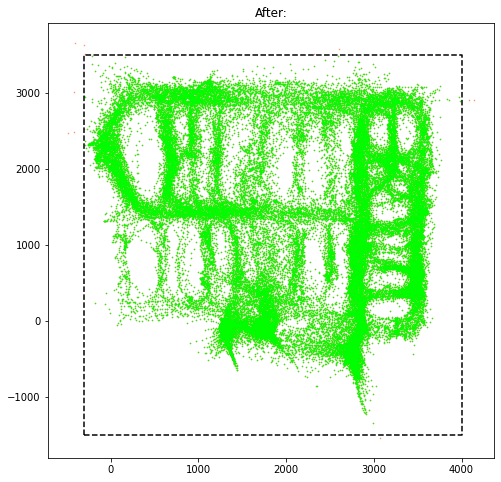

- done in 0.46 seconds
Dropped 39 rows.


In [124]:
df_removeoutside = removeOutside(
    df=df_timestampcleaner.copy(),
    printResults=True,
    plotResults=True,
    ymin=-1500,
    ymax=3500,
    xmin=-300,
    xmax=4000
)

# Outlierien poisto Isolation Forestilla

In [125]:
help(isolationForest)

Help on function isolationForest in module isolationforest:

isolationForest(df, printResults=False, max_samples=100, contamination=0.015, random_state=None, plotResults=False)
    isolationForest -function
    
    Removes outliers using Isolation Forest ML function
    
    Parameters
    ----------
    
    df :
        - dataframe from which to create visualization
        - Type: Pandas DataFrame
    
    
    printResults :
        - Type: Boolean
        - default: False
        - If True prints data of original and classified dataframe
    
    
    plotResults :
        - Type: Boolean
        - default: False
        - If True plots the original dataframe and removed outliers
    
    
    contamination:
        - Type: float
        - default: 0.015
        - The amount of contamination of the data set, 
            i.e. the proportion of outliers in the data set. 
            Used when fitting to define the threshold on the 
            scores of the samples.
        - If ‘

Running IsolationForest classifier on dataframe...
- done in 4.54 seconds


,Ennen luokittelua
shape,113374
x_max,3985
x_min,-300
y_max,3493
y_min,-1338


,Luokittelun jälkeen
shape,107765
x_max,3985
x_min,-300
y_max,3493
y_min,-1338



- Plotting dataframe...
SHAPE (1645, 11)


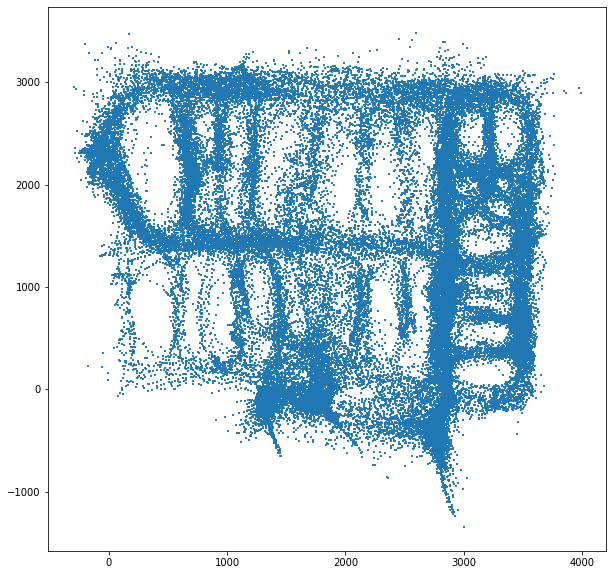

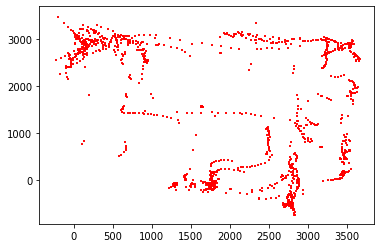

In [126]:
#df_grid = gridConverter(df_timestampcleaner.copy(),50, True)
df_isolationforest = isolationForest(
    df=df_removeoutside.copy(),
    printResults=True, 
    max_samples=100, 
    contamination=0.015, 
    random_state=None,
    plotResults=True)

# Sovitus gridiin gridconverterilla

In [127]:
help(gridConverter)

Help on function gridConverter in module gridconverter:

gridConverter(df, gridsize, printresults, x_range, y_range, create_indexes)
    gridConverter -function
    
    Converts dataframe coordinates into a gridsize²
    
    Parameters
    ----------
    
    df :
        - Type: Pandas DataFrame
    
    
    gridsize:
        - Type: integer
        - Size of the grid
    
    
    printResults :
        - Type: Boolean
        - If True prints data of original and gridded dataframe
        
    x_range & y_range :
        - Type: Integer Tuple
        - Give values from which to take lower and upper limits to grid
        - If None, takes lower and upper limit from dataframe min and max
        
    create_indexes :
        - Type: Boolean
        - If True, creates indexes from data grid coordinates
        - For example 2x2 grid has indexes from 0 to 3
    
    
    Returns
    -------
    
    Pandas dataframe with scaled coordinates



In [128]:
df_grid_50 = gridConverter(
    df=df_isolationforest.copy(),
    gridsize=50, 
    printresults=True,
    x_range=(-300,4000),
    y_range=(-1500,3500),
    create_indexes=True)

df_grid_50.sample(5)

Converting dataframe 4300 x 5000 to 50 x 50 grid...
- done in 0.01 seconds


,Ennen gridiin sovitusta
x_max,3985
x_min,-300
y_max,3493
y_min,-1338


,Gridiin sovituksen jälkeen
x_max,48
x_min,0
y_max,48
y_min,1


,node_id,timestamp,x,y,z,q,day,month,year,date,x_grid,y_grid,grid_index
6827,-2393099149039893844,2020-07-28 13:47:13+03:00,1718,-89,100,0,28,7,2020,2020-07-28,22,13,672
104434,-2393099149040559089,2020-07-28 18:21:19+03:00,3441,414,100,0,28,7,2020,2020-07-28,42,18,942
95319,-2393099149040558686,2020-07-28 20:39:09+03:00,1786,-141,100,0,28,7,2020,2020-07-28,23,13,673
60766,-2393099149039894356,2020-07-28 13:56:32+03:00,1629,1581,100,0,28,7,2020,2020-07-28,21,30,1521
27511,-2393099149039893967,2020-07-28 11:34:27+03:00,2774,-322,100,0,28,7,2020,2020-07-28,35,11,585


In [129]:
#df_grid_50['grid_index'].value_counts()

In [130]:
df_grid_200 = gridConverter(
    df=df_isolationforest.copy(),
    gridsize=200, 
    printresults=True,
    x_range=None,
    y_range=None,
    create_indexes=True)

df_grid_200.sample(3)

Converting dataframe 4285 x 4831 to 200 x 200 grid...
- done in 0.01 seconds


,Ennen gridiin sovitusta
x_max,3985
x_min,-300
y_max,3493
y_min,-1338


,Gridiin sovituksen jälkeen
x_max,199
x_min,0
y_max,199
y_min,0


,node_id,timestamp,x,y,z,q,day,month,year,date,x_grid,y_grid,grid_index
109761,-2393099149040559178,2020-07-28 16:16:14+03:00,2301,-3,100,0,28,7,2020,2020-07-28,120,54,10920
35865,-2393099149039894120,2020-07-28 08:16:56+03:00,2771,-241,100,0,28,7,2020,2020-07-28,142,45,9142
98201,-2393099149040558689,2020-07-28 17:35:47+03:00,1069,3137,100,0,28,7,2020,2020-07-28,63,184,36863


# HeatMap

In [131]:
help(heatMap)

Help on function heatMap in module heatmap:

heatMap(df, size, plotResults=False, removeTop=0)
    heatMap -function
    
    Creates a numpy array from dataframe coordinates
    
    Parameters
    ----------
    
    df :
        - dataframe from which to create array
        - Type: Pandas DataFrame
    
        
    plotResults :
        - Type: Boolean
        - default: False
        - If True plots the heatmap
    
    
    removeTop :
        - Type: Float
        - default: 0
        - If 0 < removeTop < 100, scales input percentile from top
        - Good values are somewhere between 98 - 99.99 
        
    size :
        - Type: Integer
        - If gridconverter was run with x_range and y_range, you have to input correct gridsize here
        - For example 50, for grid of 50x50
    
    
    Returns
    -------
    
    Numpy array that has frequency of each coordinate.



Running heatMap-function on dataframe...
- plotting results...


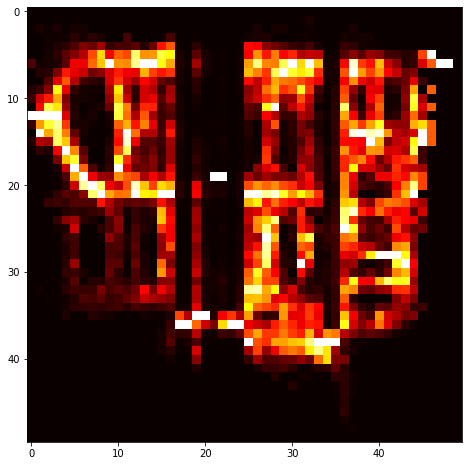

- done in 2.6 seconds


In [132]:
numpy_heatmap_50 = heatMap(
    df=df_grid_50,
    plotResults=True,
    removeTop=0,
    size=50)

Running heatMap-function on dataframe...
- plotting results...


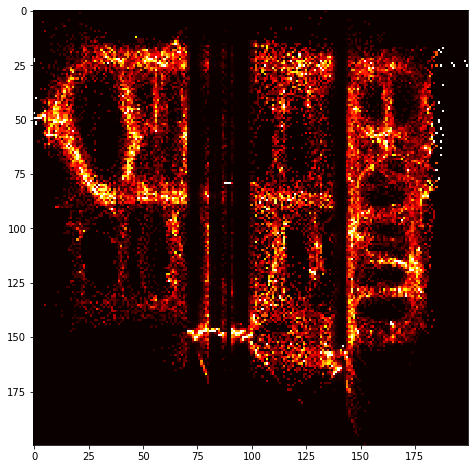

- done in 2.76 seconds


In [133]:
numpy_heatmap_200 = heatMap(
    df=df_grid_200,
    plotResults=True,
    removeTop=0,
    size=None)

# Muuta

## Color List

Creating a list of matlplotlib colors..
- done in 0.0 seconds
Length of color list: 1163


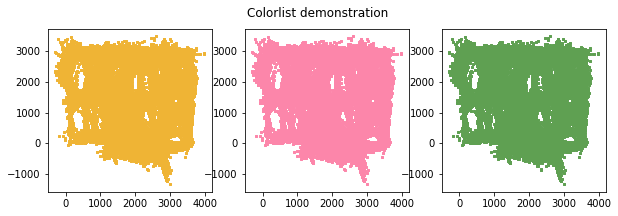

In [134]:
mycolorlist = getColorList()

fig = plt.figure(figsize=(10,3))
ax = fig.subplots(1,3)

fig.suptitle('Colorlist demonstration')
print("Length of color list:",len(mycolorlist))

ax[0].scatter(df_grid_50['x'],df_grid_50['y'],2,marker="s", c=mycolorlist[15])
ax[1].scatter(df_grid_50['x'],df_grid_50['y'],2,marker="s", c=mycolorlist[200])
ax[2].scatter(df_grid_50['x'],df_grid_50['y'],2,marker="s", c=mycolorlist[500])
plt.show()


## Shorten Node Id

In [135]:
df_grid_50_shorten_node_id = shorten_node_id(
    df=df_grid_50.copy(),
    inplace=False)

#for node_id in df[node_id].unique():
#    print(node_id)

Short	Original
1	-2393099149039893833
2	-2393099149039893844
3	-2393099149039893848
4	-2393099149039893859
5	-2393099149039893963
6	-2393099149039893967
7	-2393099149039894097
8	-2393099149039894112
9	-2393099149039894120
10	-2393099149039894124
11	-2393099149039894127
12	-2393099149039894248
13	-2393099149039894356
14	-2393099149039894370
15	-2393099149039894378
16	-2393099149039894500
17	-2393099149039894525
18	-2393099149040558671
19	-2393099149040558682
20	-2393099149040558686
21	-2393099149040558689
22	-2393099149040558808
23	-2393099149040559089
24	-2393099149040559178

- done in 0.63 seconds


## Print Unique Nodes

In [136]:
unique_node_ids = print_unique_nodes(df_grid_50_shorten_node_id, print_nodes=True)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24

- done in 0.0 seconds


## Create Node Dictionary

In [137]:
distinct_nodes = create_node_dictionary(df_grid_50_shorten_node_id)
    
distinct_nodes[9].head(5)


- done in 0.08 seconds


,node_id,timestamp,x,y,z,q,day,month,year,date,x_grid,y_grid,grid_index
35769,9,2020-07-28 08:00:01+03:00,2774,-253,100,0,28,7,2020,2020-07-28,35,12,635
35770,9,2020-07-28 08:00:11+03:00,2773,-247,100,0,28,7,2020,2020-07-28,35,12,635
35771,9,2020-07-28 08:00:20+03:00,2773,-246,100,0,28,7,2020,2020-07-28,35,12,635
35772,9,2020-07-28 08:00:30+03:00,2773,-246,100,0,28,7,2020,2020-07-28,35,12,635
35773,9,2020-07-28 08:00:39+03:00,2772,-245,100,0,28,7,2020,2020-07-28,35,12,635


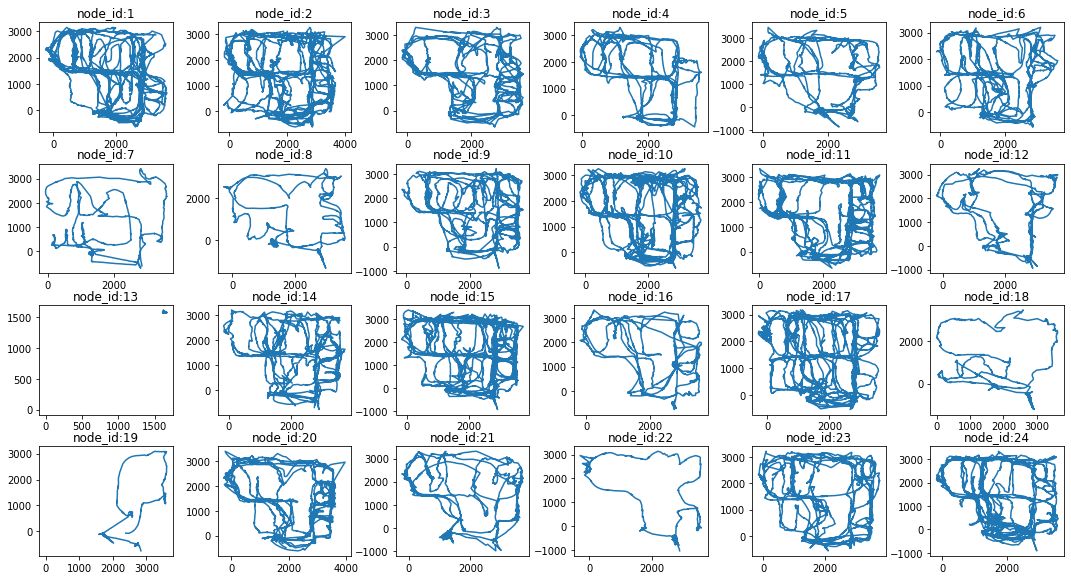

In [138]:
fig, axs = plt.subplots(4,6, figsize=(15, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.tight_layout()

axs = axs.ravel()

for i in range(1,25):
    axs[i-1].plot(distinct_nodes[i]['x'],distinct_nodes[i]['y'],1)
    axs[i-1].set_title("node_id:"+str(i))

# Reitit

In [139]:
df_routes = route_creator(df_isolationforest.copy())
df_routes.head(5)

Determining shopping routes and creating necessary columns...

List of shopping routes:

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]

- done in 0.78 seconds


,node_id,timestamp,x,y,z,q,day,month,year,date,area,endRow,startRow
0,-2393099149039893833,2020-07-28 10:07:15+03:00,1643,-199,100,0,28,7,2020,2020-07-28,-2,0,0
1,-2393099149039893833,2020-07-28 11:04:35+03:00,1876,-240,100,0,28,7,2020,2020-07-28,-2,0,0
2,-2393099149039893833,2020-07-28 11:11:12+03:00,2061,-268,100,0,28,7,2020,2020-07-28,0,0,0
3,-2393099149039893833,2020-07-28 11:13:06+03:00,2203,-278,100,0,28,7,2020,2020-07-28,0,0,0
4,-2393099149039893833,2020-07-28 11:13:08+03:00,2428,-374,100,0,28,7,2020,2020-07-28,0,0,0


Short	Original
1	-2393099149039893833
2	-2393099149039893844
3	-2393099149039893848
4	-2393099149039893859
5	-2393099149039893963
6	-2393099149039893967
7	-2393099149039894097
8	-2393099149039894112
9	-2393099149039894120
10	-2393099149039894124
11	-2393099149039894127
12	-2393099149039894248
13	-2393099149039894356
14	-2393099149039894370
15	-2393099149039894378
16	-2393099149039894500
17	-2393099149039894525
18	-2393099149040558671
19	-2393099149040558682
20	-2393099149040558686
21	-2393099149040558689
22	-2393099149040558808
23	-2393099149040559089
24	-2393099149040559178

- done in 0.62 seconds
- done in 0.06 seconds
Plotataan annetun kärryn/korin reitti:


Anna plotattavan kärryn/korin node_id:  4


Noden  4 reitit:
[-2  0 -1  9 10 11 12 13]


Valitse reitti:  10


Plotataan reitti:  10


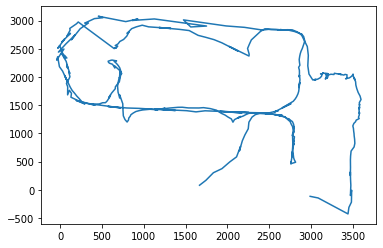

- done in 0.13 seconds.


In [140]:
shorten_node_id(df_routes, inplace=True)
node = create_node_dictionary(df_routes)
reittiplot(node)

In [141]:
df_routes_grid_50 = gridConverter(
    df=df_routes.copy(),
    gridsize=50, 
    printresults=True,
    x_range=(-300,4000),
    y_range=(-1500,3500),
    create_indexes=True)

df_grid_50.sample(5)

Converting dataframe 4300 x 5000 to 50 x 50 grid...
- done in 0.01 seconds


,Ennen gridiin sovitusta
x_max,3985
x_min,-300
y_max,3493
y_min,-1338


,Gridiin sovituksen jälkeen
x_max,48
x_min,0
y_max,48
y_min,1


,node_id,timestamp,x,y,z,q,day,month,year,date,x_grid,y_grid,grid_index
96556,-2393099149040558689,2020-07-28 15:55:54+03:00,624,2570,100,0,28,7,2020,2020-07-28,10,39,1960
57581,-2393099149039894248,2020-07-28 19:19:18+03:00,-160,2104,100,0,28,7,2020,2020-07-28,1,35,1751
103931,-2393099149040559089,2020-07-28 17:34:02+03:00,719,2767,100,0,28,7,2020,2020-07-28,11,41,2061
20560,-2393099149039893859,2020-07-28 20:36:17+03:00,1029,2913,100,0,28,7,2020,2020-07-28,15,43,2165
6009,-2393099149039893844,2020-07-28 13:02:59+03:00,3491,624,100,0,28,7,2020,2020-07-28,43,20,1043


In [142]:
df_routes['area'].unique()

array([-2,  0, -1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
       15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43])

Running heatMap-function on dataframe...
- Displaying only selected 4 routes
- Filtered 106810 lines
- plotting results...


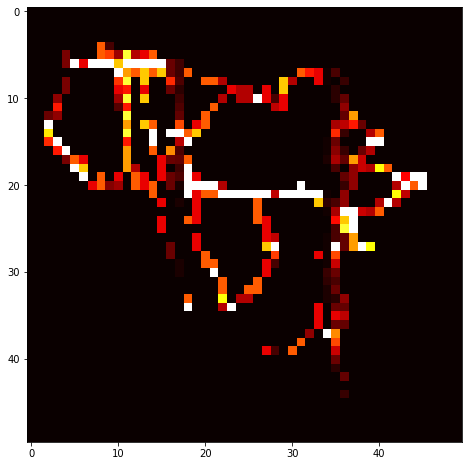

- done in 0.19 seconds


In [143]:
routes_list = [17,4,6,9]

numpy_heatmap_routes_50b = heatMap_routes(
    df=df_routes_grid_50,
    routes=routes_list,
    plotResults=True,
    removeTop=0,
    size=50)

Converting dataframe 4300 x 5000 to 80 x 80 grid...
- done in 0.02 seconds
Running heatMap-function on dataframe...
- Displaying only selected 4 routes
- Filtered 106810 lines
- plotting results...


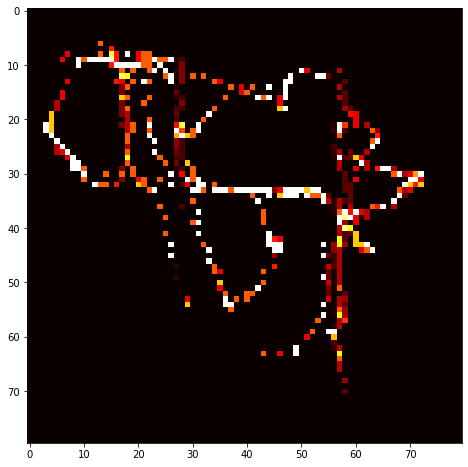

- done in 0.44 seconds


In [144]:
df_routes_grid_80 = gridConverter(
    df=df_routes.copy(),
    gridsize=80, 
    printresults=False,
    x_range=(-300,4000),
    y_range=(-1500,3500),
    create_indexes=True)

routes_list = [17,4,6,9]

numpy_heatmap_routes_80 = heatMap_routes(
    df=df_routes_grid_80,
    routes=routes_list,
    plotResults=True,
    removeTop=0,
    size=80)

In [145]:
df_routes.sample(3)

,node_id,timestamp,x,y,z,q,day,month,year,date,area,endRow,startRow
65926,14,2020-07-28 13:59:07+03:00,1735,-92,100,0,28,7,2020,2020-07-28,-2,0,0
61253,13,2020-07-28 15:12:40+03:00,1629,1583,100,0,28,7,2020,2020-07-28,0,0,0
56602,12,2020-07-28 16:14:25+03:00,1789,-49,100,0,28,7,2020,2020-07-28,-2,0,0


In [146]:
import numpy as np
import pandas as pd

routes = df_routes['area'].unique()
routes = np.delete(routes, np.where(routes < 1))

shopping_routes = []

for i in range (0,len(routes)):
    df_oneroute = df_routes[df_routes['area'].isin([routes[i]])]
    route_number = routes[i]
    route_time = df_oneroute['timestamp'].max()-df_oneroute['timestamp'].min()
    df_oneroute['distance'] = np.sqrt((df_oneroute['x'].diff()**2 + df_oneroute['y'].diff()**2))
    route_lenght = int(df_oneroute['distance'].sum()/100)
    shopping_routes.append([route_number,route_time,route_lenght])


df = pd.DataFrame(data=shopping_routes, columns=["route number", "route time", "route lenght (m)"])

df
    

,route number,route time,route lenght (m)
0,1,0 days 00:08:38,307
1,2,0 days 00:07:47,309
2,3,0 days 00:08:39,189
3,4,0 days 00:05:04,194
4,5,0 days 00:03:19,126
5,6,0 days 00:18:06,155
6,7,0 days 00:12:38,170
7,8,0 days 00:06:46,254
8,9,0 days 00:05:31,132
9,10,0 days 00:16:25,352
